In [1]:
import torchphysics as tp
import pytorch_lightning as pl

Creates the plot for one single entry of the dataset for PINNs and QRES

In [2]:
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')
F = tp.spaces.R1('f')

In [3]:
square = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])

In [4]:
#model_u = tp.models.FCN(input_space=X, output_space=U, hidden=(50, 50, 50))
model_u = tp.models.QRES(input_space=X, output_space=U, hidden=(36, 36, 36))
#model_f = tp.models.FCN(input_space=X, output_space=F, hidden=(50, 50, 50))
model_f = tp.models.QRES(input_space=X, output_space=F, hidden=(36, 36, 36))
parallel_model = tp.models.Parallel(model_u, model_f)

In [5]:
import torch 
import numpy as np
scaling = 100
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X)
data = scaling * torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
data = tp.spaces.Points(data[:, 1:], U)

In [6]:
def pde_residual(x, f, u):
    return tp.utils.laplacian(u, x) + f

pde_sampler = tp.samplers.DataSampler(xx).make_static() 

pde_cond = tp.conditions.PINNCondition(module=parallel_model, sampler=pde_sampler, 
                                       residual_fn=pde_residual)

In [7]:
data_loader = tp.utils.PointsDataLoader((xx, data), batch_size=50000)
data_condition = tp.conditions.DataCondition(module=model_u,
                                             dataloader=data_loader,
                                             norm=2, 
                                             use_full_dataset=True, 
                                             weight=10000) 

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)

solver = tp.solver.Solver([pde_cond, data_condition])
trainer = pl.Trainer(gpus=1,
                     max_steps=5000,
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
#trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.5, 
                            optimizer_args={'max_iter': 2, 'history_size': 100})

#pde_cond.sampler = tp.samplers.GridSampler(square, n_points=60000).make_static()

solver = tp.solver.Solver(train_conditions=[data_condition, pde_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=10000, # number of training steps
                     logger=False,
                     benchmark=True,
                     checkpoint_callback=False)
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 11.0 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

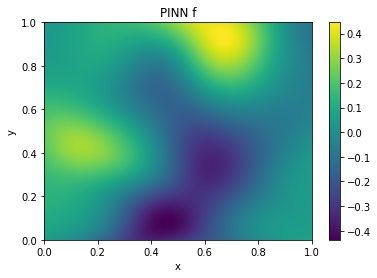

In [ ]:
# image for the learned f:
import matplotlib.pyplot as plt
from matplotlib import cm
xmin, xmax = 0, 1
ymin, ymax = 0, 1
Nx, Ny = 512, 512 
xx = np.linspace(xmin, xmax, Nx+1)
xx = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2).astype(np.float32)
xx = tp.spaces.Points(torch.tensor(xx), X)
f_out = model_f(xx).as_tensor / scaling
f_out = f_out.detach().reshape(1, Nx+1, Nx+1)
fig = plt.figure() #figsize=(10+4, 5)
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"PINN f")
plt.imshow(f_out[0], extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()

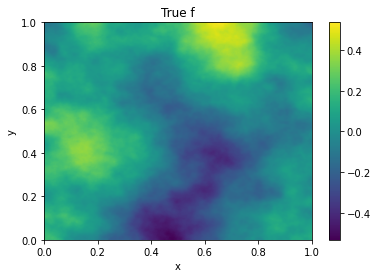

In [ ]:
# true f:
true_data = torch.tensor(np.load('poisson_data_f_u.npy').astype(np.float32))
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"True f")
plt.imshow(true_data[:, 0].reshape(Nx+1, Nx+1), extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()

tensor(0.2399)


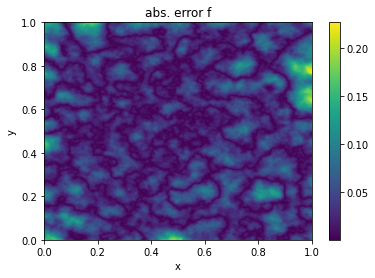

In [ ]:
# error f:
plt.xlabel('x')#, fontsize=16, labelpad=15)
plt.ylabel('y')#, fontsize=16, labelpad=15)
plt.title(r"abs. error f")
diff = np.abs(f_out[0].numpy()-true_data[:, 0].numpy().reshape(Nx+1, Nx+1))
l2_rel = np.sqrt(np.sum(diff**2))/np.sqrt(sum(true_data[:, 0]**2))
plt.imshow(diff, 
           extent=[xmin, xmax, ymin, ymax], origin='lower', aspect = 'auto')#, vmin=0, vmax=1, )
plt.colorbar()
print(l2_rel)